# Satellite EKE

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
#from gsw import SA_from_SP, p_from_z, sigma1
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import cartopy.crs as ccrs

from dask.distributed import Client

In [2]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40097 Dashboard: /proxy/42823/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


Load Josue's satellite and ACCESS-OM2-01 IAF EKE data (geostrophic, 1/2 (u'^2+v'^2))

In [4]:
EKE = xr.open_dataset('/home/156/jm5970/v45/data.input/mean_eke.nc').EKE_eddy

josue's data
9629 days for satellite means

1993-2018 for 3rd cycle 

In [5]:
# 3rd cycle of IAF:
EKE_clim_ACCESS = xr.open_dataset('/g/data/hh5/tmp/jm_eddy_lagrangian/climatology/3rd_cycle/MEKE_climatology_ACCESS_OM2.nc').MEKE

In [6]:
EKE_RYF = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_EKE_10yr.nc').EKE
# 10 years of RYF,code for this later in notebook

In [7]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [8]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

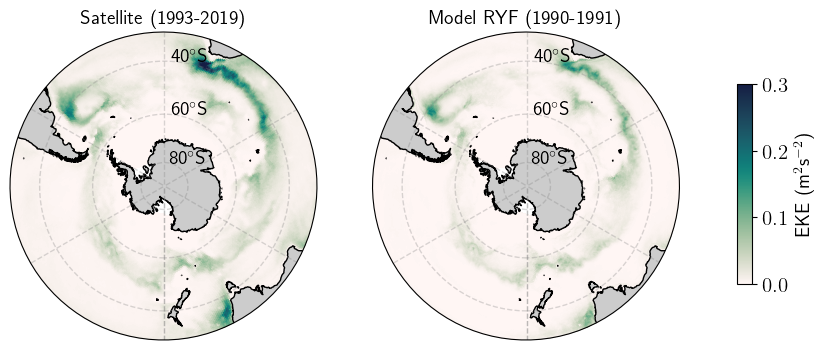

In [11]:
import matplotlib.path as mpath

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1, projection=projection)

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


p1 = EKE.plot.pcolormesh(x='lon', y='lat', add_colorbar=False, vmin=0, vmax=0.3, cmap='cmo.tempo', transform=ccrs.PlateCarree())
ax.set_title('Satellite (1993-2019)', fontsize = 14)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.ylocator = mticker.FixedLocator([-80, -60, -40])
plt.text(10,-80,'80$^\circ$S',transform=ccrs.PlateCarree(), fontsize = 14)
plt.text(5,-60,'60$^\circ$S',transform=ccrs.PlateCarree(), fontsize = 14)
plt.text(3,-40,'40$^\circ$S',transform=ccrs.PlateCarree(), fontsize = 14)



ax = plt.subplot(1, 2, 2, projection=projection)

ax.set_extent([-280, 80, -85, -30], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


p1 = EKE_RYF.plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=False, vmin=0, vmax=0.3, cmap='cmo.tempo', transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.ylocator = mticker.FixedLocator([-80, -60, -40])
plt.text(10,-80,'80$^\circ$S',transform=ccrs.PlateCarree(), fontsize = 14)
plt.text(5,-60,'60$^\circ$S',transform=ccrs.PlateCarree(), fontsize = 14)
plt.text(3,-40,'40$^\circ$S',transform=ccrs.PlateCarree(), fontsize = 14)
ax.set_title('Model RYF (1990-1991)', fontsize = 14)
plt.subplots_adjust(wspace = 0.0, hspace = 0.05, right = 0.85)
ax_cb = plt.axes([0.88, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('EKE (m$^2$s$^{-2}$)', fontsize = 14);
cb.ax.tick_params(labelsize=15)

#plt.savefig('EKEcomparison.png',dpi = 400)


# save geostrophic velocities and derive EKE from SSH for RYF

In [5]:
## FULL SO ##
lat_range = slice(-80.03,-29.99)
lat_range_big =  slice(-80.05,-29.90)


In [3]:
session = cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [6]:
yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)

In [29]:
for i in np.arange(2170,2180):
    year = str(i)
    print(i)

    start_time= year + '-01-01'
    end_time= year + '-12-31'

    # reference density value:
    rho_0 = 1035.0
    g = 9.81
    
    # Load eta_t for given year
    eta_t = cc.querying.getvar(expt,'sea_level',session,ncfile='%daily%',start_time=start_time, end_time=end_time)
    eta_t = eta_t.sel(yt_ocean=lat_range, time=slice(start_time, end_time))
    
    delta_lon = 0.1 #always
    delta_lat = yt_ocean-yt_ocean.roll(yt_ocean = 1, roll_coords = False)
    delta_lat[0]=delta_lat[1] #fudge the first one so that it's not negative
    Omega = 7.2921150*10**(-5) #rad/s
    f = 2 * Omega*np.sin(yt_ocean*(2*np.pi)/360)
    u_geostrophic = -1/f*g*eta_t.differentiate('yt_ocean')*delta_lat/dyt
    v_geostrophic = 1/f*g*eta_t.differentiate('xt_ocean')*delta_lon/dxt
    u_geostrophic = u_geostrophic.load()
    v_geostrophic = v_geostrophic.load()
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'u_geostrophic': u_geostrophic,'v_geostrophic': v_geostrophic})
    ds.to_netcdf(save_dir+'01iaf_geostrophic_velocities_'+year+'.nc')

1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [7]:
chunky = {"yt_ocean":218,"xt_ocean":400 }
year = '2170'
u_geostrophic = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_'+year+'.nc', chunks = chunky).u_geostrophic
v_geostrophic = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_'+year+'.nc', chunks = chunky).v_geostrophic
for i in np.arange(2171,2180):
    year = str(i)
    print(i)
    u_geostrophic_i = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_'+year+'.nc', chunks = chunky).u_geostrophic
    v_geostrophic_i = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_'+year+'.nc', chunks = chunky).v_geostrophic
    u_geostrophic = xr.concat([u_geostrophic, u_geostrophic_i], dim = 'time')
    v_geostrophic = xr.concat([v_geostrophic, v_geostrophic_i], dim = 'time')
u_mean = u_geostrophic.mean('time')
v_mean = v_geostrophic.mean('time')

2171
2172
2173
2174
2175
2176
2177
2178
2179


In [8]:
u_mean = u_mean.load()
v_mean = v_mean.load()
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'u_mean': u_mean,'v_mean': v_mean})
ds.to_netcdf(save_dir+'geostrophic_velocities_10yr.nc')

In [9]:
u_mean = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_10yr.nc', chunks = chunky).u_mean
v_mean = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_10yr.nc', chunks = chunky).v_mean

for i in np.arange(2170,2180):
    year = str(i)
    print(i)
    u_geostrophic = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_'+year+'.nc', chunks = chunky).u_geostrophic
    v_geostrophic = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_velocities_'+year+'.nc', chunks = chunky).v_geostrophic
    EKE = 1/2*((u_geostrophic-u_mean)**2 + (v_geostrophic-v_mean)**2).mean('time')
    EKE.load()
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'EKE':EKE})
    ds.to_netcdf(save_dir+'geostrophic_EKE_'+year+'.nc')    


2170
2171
2172
2173
2174
2175
2176
2177
2178
2179


In [10]:
chunky = {"yt_ocean":218,"xt_ocean":400 }
year = '2170'
EKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_EKE_'+year+'.nc', chunks = chunky).EKE
for i in np.arange(2171,2180):
    year = str(i)
    print(i)
    EKE_i = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/geostrophic_EKE_'+year+'.nc', chunks = chunky).EKE
    EKE = xr.concat([EKE, EKE_i], dim = 'time')
EKE_mean = EKE.mean('time')


2171
2172
2173
2174
2175
2176
2177
2178
2179


In [11]:
EKE_mean = EKE_mean.load()
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'EKE':EKE_mean})
ds.to_netcdf(save_dir+'geostrophic_EKE_10yr.nc')